In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from cycifsuite.get_data import read_synapse_file
from cycifsuite.combat import combat
from cycifsuite.unsupervised_analysis import *

from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from functools import partial

## Read data from Synapse, normalization, log2 transformation, and scaling.
### No ComBat because everything was done in the same well.
### Note, here the pooled expr data with only mean, median, std, lawsls5/9 were used.

In [2]:
expr_data = pd.read_hdf(read_synapse_file('syn18504942'))
metadata = pd.read_csv(read_synapse_file('syn18501468'), index_col=0)
metadata = metadata.loc[expr_data.index]
assert((metadata.index==expr_data.index).all())
feature_metadata = pd.read_json(read_synapse_file('syn18502301')).transpose()
# add nuclear to cytoplasm ratio
nucs = feature_metadata[(feature_metadata.feature_type=='mean')&(feature_metadata.sublocation=='nuc')&(feature_metadata.marker!='none')].index
cytoplasms = feature_metadata[(feature_metadata.feature_type=='mean')&(feature_metadata.sublocation=='cytoplasm')&(feature_metadata.marker!='none')].index
nc_ratio = np.divide(expr_data[nucs], expr_data[cytoplasms])
# Replace nulls division by 0 nulls by mean
from sklearn.impute import SimpleImputer
imputor = SimpleImputer(strategy='mean')
nc_ratio.loc[:,:] = imputor.fit_transform(nc_ratio)
nc_ratio.columns = [x.replace('mean','NC-ratio') for x in nc_ratio.columns]
expr_data = pd.concat([expr_data,nc_ratio],axis=1)
# Normlalizing and combat
expr_data = expr_data - expr_data.min()
expr_data.loc[:,:] = scale(np.log2(expr_data + 1))
# combat_norm_data = combat(expr_data.transpose(), metadata.replicate).transpose()
# assert(combat_norm_data.notnull().all(axis=None))

Welcome, Yunguan Wang!

Welcome, Yunguan Wang!

Welcome, Yunguan Wang!



[WARNING] C:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':



## Per well clustering
### Clustering were done in UMAP 2D space with HDBSCAN clustering.

In [ ]:
metadata['pw'] = metadata.Plate.astype(str) + '_' + metadata.Well
np.random.seed(999)
clustering_func = partial(clustering_wrapper, dimention_reduction='pca+umap', use_full_dim=False, umap_min_dist=0.1)
updated_metadata = cluster_all_wells(expr_data, metadata, clustering_func, 'pw',output_dstn='d:/data/MCF10A 090718 data/well_based_analysis/per_well_clustering', verbose=False)

## Get cluster size fractions of each well for plotting

In [3]:
# Making cluster size distribution stacked barplot
updated_metadata['s_c'] = updated_metadata.pw + '_' + updated_metadata.cluster.astype(str) 
pw_to_condition_df = updated_metadata.set_index('pw', drop=False)[['ligand','pw','time']].drop_duplicates()
crit = updated_metadata.groupby(['pw','cluster']).count()['Well']
crit = crit.groupby('pw').transform(lambda x: x/x.sum())
crit = crit.reset_index()
crit['s_c'] = crit.pw + '_' + crit.cluster.astype(str) 
bar_plot_data = crit.copy()
bar_plot_data['ligand'] = pw_to_condition_df.loc[bar_plot_data.pw,'ligand'].values
bar_plot_data['time'] = pw_to_condition_df.loc[bar_plot_data.pw,'time'].values
biggest_cluster = bar_plot_data.groupby(['pw']).max()

## Actual plotting

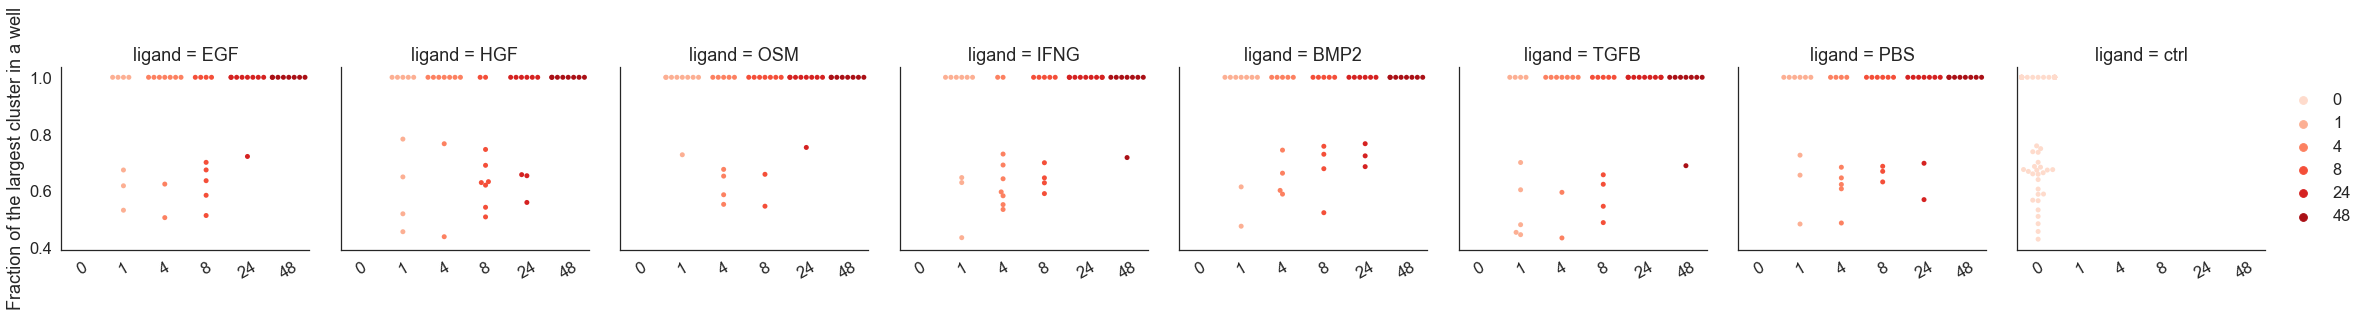

In [4]:
plot_data = biggest_cluster
sns.set(font_scale=1.5,style='white')
g = sns.catplot(x='time', y='Well', hue='time', data=plot_data, col='ligand', 
                hue_order=sorted(plot_data.time.unique()), height=4, kind='swarm', s=5,
               palette='Reds')
g.add_legend()
g.set_xticklabels(rotation=30)
g.set_ylabels('Fraction of the largest cluster in a well')
g.set_xlabels('')

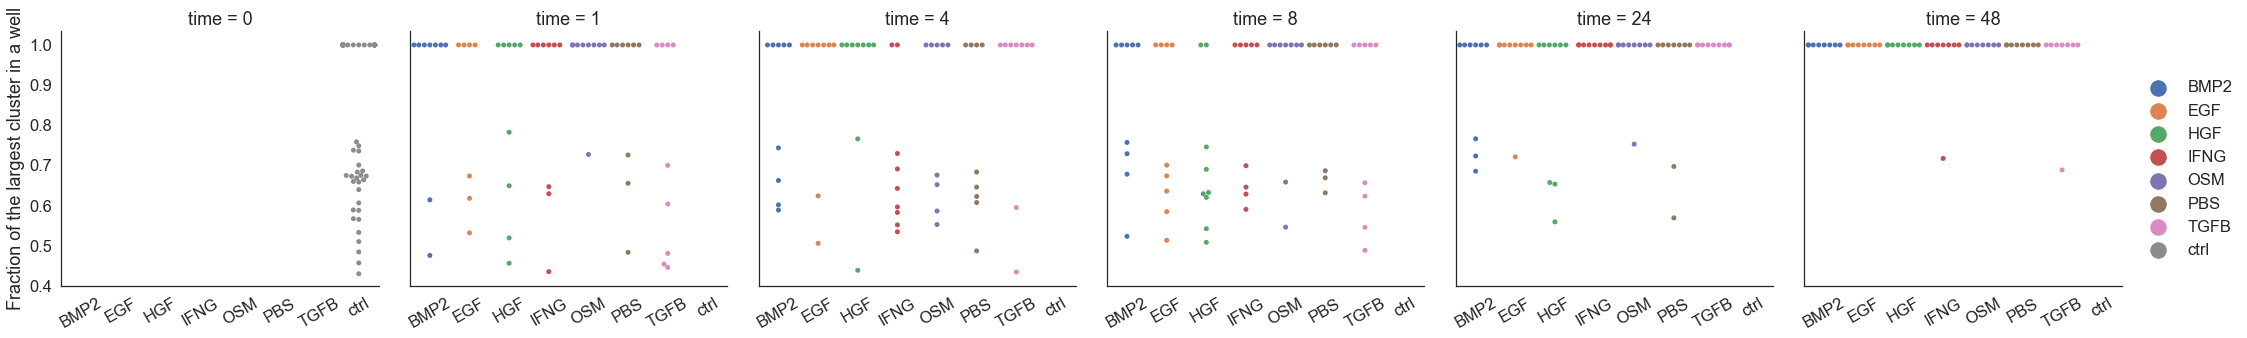

In [5]:
plot_data = biggest_cluster
sns.set(font_scale=1.5,style='white')
g = sns.catplot(x='ligand', y='Well', hue='ligand', data=plot_data, col='time', 
                hue_order=sorted(plot_data.ligand.unique()), order=sorted(plot_data.ligand.unique()),
                height=5, kind='swarm',s=5)
g.add_legend(markerscale=2)
g.set_xticklabels(rotation=30)
g.set_ylabels('Fraction of the largest cluster in a well')
g.set_xlabels('')